# Web Scraping for Indeed.com & Predicting Salaries

In this project, I practiced collecting data by scraping the job posting site Indeed.com and then built a binary classifier to predict the salaries of scraped job postings.

There were three key objectives when analyzing salary information from the examined postings. First, calculate a median salary among all available job postings with salary information. Second, build a classification model to predict whether any job without a listed salary was likely to fall above or below the median salary value. Finally, identify those skills and key terms most associated with jobs above the median salary value.

As we go through each section of the project, I will occassionally pause to review what I found, and how I determined my next steps.

Below is an executive summary of my findings.  If you would like to review the actual code used in scraping, cleaning, and modeling the data, you may skip the remainder of this section to the code blocks below.

## Executive Summary

To briefly review the outcomes of this project, I scraped information on nearly 6,400 distinct data science job postings from 17 different cities (e.g., New York, Chicago, Washington DC). Individual job posting data comprised information including city/location, job title, company name, and a brief summary of job duties. 

Salary information was available for a limited subset (449) of the job posts surveyed. Where necessary, salaries were converted into annual salary estimates (if salaries were posted for monthly or hourly rates). If salaries were posted as ranges (e.g., 75,000 – 90,000 dollars), analyzes utilized a simple average of the listed salary range for each posting. 

##### Assessing the Data

Among 449 jobs postings with salary information, the median annual salary was 87,915 (dollars), with a range of annual salaries between 22,100 and 270,400.

I employed natural language processing (NLP) to examine the terms and phrases most associated with above-median salaries. This was done in part by examining the frequency with which terms appeared in above-median salary postings compared to their appearance in below-median salary postings. NLP examined terms with a certain minimum frequency (appearing in at least five percent of postings), to avoid examining terms that were too infrequent to be useful predictors.

In job titles, terms like "data scientist," "machine learning," "engineer," and “data" were all positively associated with above median salaries, while terms like "research," "analyst," and "associate" were associated with below median income.

Similarly, in job summaries, terms like "machine learning," "data scientist," "data science," "senior," "lead," "big data," "analytics," and "years" (presumably looking for at least so many years of prior experience) were all associated with above median salaries, while "research," "analyze," and "analysis" were all associated with below median salaries.

With respect to location, jobs posted in the Chicago, Washington DC, and San Francisco areas were all strongly associated with above-median salaries. Surprisingly, Seattle was the city most strongly associated with below-median salaries. However, it may be that higher salary jobs posted from the Seattle area were posted without salary information available. If employers from a given area tend not to post their higher paying jobs with salary information, those postings that do include salary information could skew data to imply that jobs on average pay less in an area than they actually do.

Assessing company names was not greatly helpful for purposes of this analysis, as company names can include a lot of unique words or acronyms that do not necessarily translate to the type of NLP involved in these efforts. Still, among the data examined, the term “associates” (presumably referring to consulting firms) was associated with above median salaries, while "university" postings were associated with below median salaries. 

##### Developing the Predictive Model

Utilizing the insights derived above, I explored several different modeling techniques when predicting salary information. A logistic regression model developed with eight variables appeared to maximize predictive value while utilizing the fewest number of predictor variables. 

The model examined eight aspects of each posting when predicting whether salary would be above or below the median value:    
•	Was the job located in Chicago, Washington DC, or San Francisco?    
•	Did the job title contain “strong” terms including "data scientist, " "machine," "learning," or "engineer"?    
•	Did the job title contain “weak” terms including "research," "analyst," or "associate"?    
•	Did the company name include the “strong” term “associates”?    
•	Did the company name include the “weak” term “university”?    
•	Was the job posting located in the city of its posting, or in a nearby area (e.g., being in Seattle vs. Redmond, Washington)?    
•	Did the job summary contain “strong” terms including "machine learning," "data scientist," "data science," "senior," "lead," "big data," "analytics," or "years"?     
•	Did the job summary contain “weak” terms including "research," "analyze," and "analysis"?    

Examining these eight questions in each job post allowed for above- vs. below-median salary to be correctly predicted in 83% of the test data set. 

##### Predicting Salaries of Job Postings with No Salary Information
When applying the predictive model to the remaining 5,950 job postings without salary information listed, 3,128 jobs (52 percent) were predicted to have salaries below the median, while 2,822 (48 percent) were predicted to be above the median.  Under ideal circumstances, we would expect approximately 50 percent of postings to be below the median and approximately 50 percent to be above the median. As such, the predictive results are encouraging with respect to correct classification.

Among the predicted results, San Francisco is predicted to be the biggest hub of above median salary jobs, and had the highest predicted ratio of above median jobs to below median jobs (2.87 above-median jobs for every below-median job). Chicago also had a predicted ratio of 2.06 above-median jobs for every below-median job.

The least appealing cities for data science jobs included Miami (8.63 below-median jobs for every above-median job), Philadelphia (4.16 below-median jobs for every above-median job), and Houston (2.79 below-median jobs for every above-median job).

##### Limitations and Considerations

While this evaluation has produced valuable information on the expected salaries of data science jobs in various regions of the United States, there are several caveats worth raising regarding these findings.

First, the predictive ability of this model is somewhat restricted to job postings from cities that were initially surveyed. If job postings would be added from cities not in the initial set, the predictive ability of the model would not be able to account for locations that were not assessed during the model’s creation.

Second, the classification model inherently assumes that the distribution of salaries for jobs with listed salaries is approximately the same as without listed salaries. As noted above, employers listing higher paying jobs may intentionally not post salary information with their postings, which could lead to jobs with unposted salaries following a different distribution than those jobs with posted salaries.   

Finally, while the classification model utilized binary variables (that is, indicated yes or no for a given item), they may be adjusted in future evaluations to capture a gradient of information, which could improve the predictive ability of the model. That is, certain “strong” terms like “data scientist” or “machine learning” could be more powerfully predictive of above-median salary than other “strong” terms like “engineer”. Capturing the relative strength or weakness of these terms could help to further distinguish the likelihood of above- or below-median salaries depending on their relative presence in any given job posting.

### Importing Initial Libraries

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

### Scraping job listings from Indeed.com

I scraped job listings from Indeed.com using BeautifulSoup.   

In assembling my scraper, I examined the html tags of a typical indeed page to determine where each element of a job posting (job title, company name, location, job summary, and salary) was located.  I also took note of the basic structure of indeed urls, which follow a basic pattern dependant on the job descriptors and location one is searching. 

Initial conditions for each scrape included defining a list of cities to target, and specifying the number of results from each city I wanted to scrape. Further customization could be added to expand the list of search terms (beyond "data scientist") without too much trouble.

Note: this scraping was conducted in April of 2017. 

In [3]:
#assembling the entire webscraping process:

#Detailing number of results we want to scrape for each city (for my biggest scrape, I did 5000)
max_results_per_city = 20
# Crawling more results will also take much longer.

city_set = ['New+York','Chicago','San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Washington+DC', 'Boulder']

#creating sample dataframe to house scraped data - specifying column names for each piece of information to be stored
columns = ["city", "job_title","company_name","location","summary","salary"]
sample_df = pd.DataFrame(columns = columns)

#scraping code:
for city in city_set:    #for each city in the city list,
    #noting we'll want to iterate through our max results by groups (steps) of 10
    for start in range(0, max_results_per_city, 10):    
        #retrieving html from each page by inserting city name and range figures into known URL patterns
        #sleeping one second between page scrapes
        #parsing html using BeautifulSoup and saving as variable "soup"
        page = requests.get('http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=' + str(city) + '&start=' + str(start))
        time.sleep(1)
        soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
        for div in soup.find_all(name="div", attrs={"class":"row"}):   #for every job entry in the html page
            num = (len(sample_df) + 1)  #noting next row of dataframe to store new job_post info
            job_post = []    #create an empty list to store the values of info to be appended to the data frame
            #appending city name to job_post
            job_post.append(city) 
            #grabbing job title
            for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
                    job_post.append(a["title"])   #appending job title to job_post
            #grabbing company name
            company = div.find_all(name="span", attrs={"class":"company"}) #most company information is found here.
            if len(company) > 0:   #if there's at least one span tag with class:company, it'll contain the company name
                for b in company:
                    job_post.append(b.text.strip())  #appending company name to job_post
            else:               #if not, it'll be in a specialty tag of class:result-link-source
                sec_try = div.find_all(name="span", attrs={"class":"result-link-source"})
                for span in sec_try:
                    job_post.append(span.text)     #appending company name to job_post
            #grabbing location name
            c = div.findAll('span', attrs={'class': 'location'})  #find all span tags in entry with class = location
            for span in c:  #looking through all span tags...
                job_post.append(span.text)  #appending location name to job_post
            #grabbing summary text
            d = div.findAll('span', attrs={'class': 'summary'})   #find all span tags in entry with class = summary
            for span in d:
                job_post.append(span.text.strip()) #appending summary information to job post
            #grabbing salary data
            try:
                job_post.append(div.find('nobr').text) #if salary info is in 'nobr' tag, grab it,
            except:
                try:
                    div_two = div.find(name="div", attrs={"class":"sjcl"})  #otherwise, look for div tags with class:sjcl
                    div_three = div_two.find("div")  #and then look for div tags within and grab text (which will be salary)
                    job_post.append(div_three.text.strip())
                except:
                    job_post.append("Nothing_found")   #otherwise, note that nothing was found
            #appending contents of job_post to bottom of dataframe
            if len(job_post)==6:  #ensuring that job_post has all required elements before appending to df.
                sample_df.loc[num] = job_post


#saving sample_df as a local csv file  - define your own local path to save contents 
#alter number at end of file path each time to ensure you're not overwriting previous scrape data.   

#sample_df.to_csv("new_scrape_data.csv", encoding='utf-8')
        
#after completing the process, print out the sample df to show it's worked. 
sample_df.head()

,city,job_title,company_name,location,summary,salary
1,New+York,Senior Data Scientist,Verizon,"Orangeburg, NY 10962",Familiarity and experience with creating analy...,Nothing_found
2,New+York,Data Scientist - Big Data & Analytics,KPMG,"New York, NY 10154",KPMG is currently seeking a Data Scientist - B...,Nothing_found
3,New+York,Data Scientist,Komodo Health,"New York, NY",Experience working with proprietary secondary ...,Nothing_found
4,New+York,"Quantitative Analyst, Associate",Citi,"New York, NY","Design, develop, implement and test tools for ...",Nothing_found
5,New+York,"Research Analyst, Content Insights",Spotify,"New York, NY 10011 (Chelsea area)",You have experience working with individual re...,Nothing_found


### Data Cleaning

Now that we've scraped the data, we'll need to do some initial cleaning. A few notes going in:

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, and so need to be converted to annual approximations
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.


In [4]:
#reading csv with index_col = 0, otherwise I get an additional unnamed column of separate index values

#point read_csv function toward own scraped file source
scrape_data = pd.read_csv("data/scrape_data.csv", index_col=0)

scrape_data.shape

(128289, 6)

In [5]:
#dropping any duplicate rows:
scrape_data = scrape_data.drop_duplicates()
scrape_data.reset_index(drop=True, inplace=True)
scrape_data.shape

(6399, 6)

Replacing "+" symbols here in city names with spaces. I don't necessarily need underscores to connect city names since NLP can examine n-gram sizes of multiple words, and because multi-word city names are already disconnected in location data.

In [6]:
scrape_data["city"] = scrape_data["city"].str.replace("+"," ")
scrape_data.head()

,city,job_title,company_name,location,summary,salary
0,New York,Data Scientist - Big Data & Analytics,KPMG,"New York, NY 10154",KPMG is currently seeking a Data Scientist - B...,Nothing_found
1,New York,People Analytics & Research Data Scientist,BlackRock,"New York, NY 10001",We are looking for a data scientist with advan...,Nothing_found
2,New York,Data Scientist,KPMG,"New York, NY 10154",KPMG is currently seeking a Data Scientist to ...,Nothing_found
3,New York,Data Scientist,PulsePoint,"New York, NY",\n3+ years of full-time experience working as ...,Nothing_found
4,New York,Data Scientist,MassMutual Financial Group,"New York, NY 10261 (Murray Hill area)",\nMassMutual’s Advanced Analytics group is see...,Nothing_found


In [7]:
#some targeted cleaning of salary information to make parsing easier - remove "\n", "$", and ","

scrape_data["salary"] = scrape_data["salary"].str.replace("\n", "")
scrape_data["salary"] = scrape_data["salary"].str.replace(",", "")
scrape_data["salary"] = scrape_data["salary"].str.replace("$", "")


In [8]:
#I want to preserve information about the original salary time-data (yearly, monthly, etc.) 
#in case I want to study differences between these groups at a later time.

scrape_data["og_salary_period"] = np.nan

#if the salary contains information on time period, save that time period 
#string in the og_salary_period column
scrape_data.ix[scrape_data["salary"].str.contains("year"), "og_salary_period"] = "year"
scrape_data.ix[scrape_data["salary"].str.contains("month"), "og_salary_period"] = "month"
scrape_data.ix[scrape_data["salary"].str.contains("week"), "og_salary_period"] = "week"
scrape_data.ix[scrape_data["salary"].str.contains("day"), "og_salary_period"] = "day"
scrape_data.ix[scrape_data["salary"].str.contains("hour"), "og_salary_period"] = "hour"



In [9]:
#filtering out the results with salary data != "Nothing_found"
salary_data = scrape_data[scrape_data["salary"] != "Nothing_found"]
salary_data

#removing all rows in salary data from scrape data, and converting all "Nothing_found" 
#values to NaN, so that float salary values can be easily reintegrated later
scrape_data = scrape_data[~scrape_data.isin(salary_data)].dropna(how='all')
scrape_data["salary"].replace("Nothing_found",np.nan, inplace=True)
scrape_data["salary"].astype('float')

print(salary_data.shape)
print(scrape_data.shape)

(449, 7)
(5950, 7)


In [10]:
#separating out data based on whether contains hour, day, week, month, year

year_salaries = salary_data[salary_data["salary"].str.contains("year")]
month_salaries = salary_data[salary_data["salary"].str.contains("month")]
week_salaries = salary_data[salary_data["salary"].str.contains("week")]
day_salaries = salary_data[salary_data["salary"].str.contains("day")]
hour_salaries = salary_data[salary_data["salary"].str.contains("hour")]


In [11]:
# removing string values(" a year", " a week", etc. from salary dfs)

year_salaries["salary"] = year_salaries["salary"].str.replace(" a year", "")
month_salaries["salary"] = month_salaries["salary"].str.replace(" a month", "")
week_salaries["salary"] = week_salaries["salary"].str.replace(" a week", "")
day_salaries["salary"] = day_salaries["salary"].str.replace(" a day", "")
hour_salaries["salary"] = hour_salaries["salary"].str.replace(" an hour", "")



/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

The following function effectively tests each cell in a series for a '-' sign, and splits on teh hyphen if it appears. It then returns the average of the two values separated by the hyphen. If there is no '-', then the function just returns the value as float.


In [12]:
def split_sal(i):
    try:
        splt = i.split(' - ',1)
        first = float(splt[0])
        second = float(splt[1])
        return (first + second)/2
    except:
        return float(i)

In [13]:
year_salaries["salary"] = year_salaries["salary"].apply(split_sal)

month_salaries["salary"] = month_salaries["salary"].apply(split_sal)
month_salaries["salary"] = month_salaries["salary"] * 12

week_salaries["salary"] = week_salaries["salary"].apply(split_sal)
week_salaries["salary"] = week_salaries["salary"] * 52

day_salaries["salary"] = day_salaries["salary"].apply(split_sal)
day_salaries["salary"] = day_salaries["salary"] * 260

hour_salaries["salary"] = hour_salaries["salary"].apply(split_sal)
hour_salaries["salary"] = hour_salaries["salary"] * 2080


/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [14]:
#rejoining salary data into main scrape_data df
combined_salaries = pd.concat([year_salaries, month_salaries, week_salaries, day_salaries, hour_salaries], axis=0)
combined_salaries.shape

(449, 7)

In [15]:
scrape_data = pd.concat([scrape_data, combined_salaries], axis=0)
scrape_data.shape

(6399, 7)

In [16]:
scrape_data.dtypes

city                 object
job_title            object
company_name         object
location             object
summary              object
salary              float64
og_salary_period     object
dtype: object

In [17]:
#targeted replace of "r&d" in job titles and summaries with "research development", 
#as I want to remove "&" from listings as part of general clean-up

scrape_data["job_title"] = scrape_data["job_title"].str.replace("R&D", "research development")
scrape_data["summary"] = scrape_data["summary"].str.replace("R&D", "research development")


In [18]:
scrape_data.tail()

,city,job_title,company_name,location,summary,salary,og_salary_period
5910,Washington DC,"Linux Systems-HPC, Clustering",Workbridge Associates,"Washington, DC",\nBig Data Experience. Communication is critic...,150800.0,hour
5942,Washington DC,Office of the Science Advisor Strategic Coordi...,Oak Ridge Associated Universities,"Washington, DC",\nExperience conducting analysis of data and i...,60902.4,hour
6067,Washington DC,Environmental Health Assessment Support at EPA,Oak Ridge Associated Universities,"Arlington, VA",\nAssisting IRIS Division scientists in specia...,45344.0,hour
6197,Boulder,Horticultural Data Analyst (Cannabis Industry),Riderflex,"Denver, CO",\nCreate real-time electronic platform for new...,27040.0,hour
6209,Boulder,research development Technician,Apex Life Sciences,"Denver, CO",\nStrong data entry skills. Assist in analytic...,35360.0,hour


Creating a data character cleaning function, and applying to all columns. Also lowercasing all string data for ease of later NLP.


In [19]:
def data_clean(df, column):
    cleaning_list = ["+", "$","/",",","?",".",";","-","@","!","&","%","^","*",")","(", "\n"]
    for item in cleaning_list:
        df[column] = df[column].str.replace(item, " ")
        df[column] = map(str.lower, df[column])

#can't clean the salary column due to float values, and don't need to clean og_salary, 
#so keeping out of the for loop
for column in scrape_data.columns[0:len(scrape_data.columns)-2]:
    data_clean(scrape_data, column)

scrape_data.tail()

,city,job_title,company_name,location,summary,salary,og_salary_period
5910,washington dc,linux systems hpc clustering,workbridge associates,washington dc,big data experience communication is critica...,150800.0,hour
5942,washington dc,office of the science advisor strategic coordi...,oak ridge associated universities,washington dc,experience conducting analysis of data and in...,60902.4,hour
6067,washington dc,environmental health assessment support at epa,oak ridge associated universities,arlington va,assisting iris division scientists in special...,45344.0,hour
6197,boulder,horticultural data analyst cannabis industry,riderflex,denver co,create real time electronic platform for new ...,27040.0,hour
6209,boulder,research development technician,apex life sciences,denver co,strong data entry skills assist in analytica...,35360.0,hour


Where location == "united states", I filled this in with the city location name, otherwise it'll be useless if more than one city has location data of "united states".

I'm also preemptively simplfying location data to include only city and state, cutting data off at zip code to make further analyses easier. I realize I'm losing some information with this, but it makes examining groups of locations
easier, with fewer unique representations of the same places that won't add much to NLP analysis.


In [20]:
#using numpy is faster than using .replace
scrape_data['location'] = np.where(scrape_data['location'] == "united states", 
                                   scrape_data["city"], scrape_data['location'])

#note - " \d" splits information on the first numeric digit in the string.
scrape_data["location"] = scrape_data["location"].str.split(' \d', expand=True, n=1)

scrape_data.tail()

,city,job_title,company_name,location,summary,salary,og_salary_period
5910,washington dc,linux systems hpc clustering,workbridge associates,washington dc,big data experience communication is critica...,150800.0,hour
5942,washington dc,office of the science advisor strategic coordi...,oak ridge associated universities,washington dc,experience conducting analysis of data and in...,60902.4,hour
6067,washington dc,environmental health assessment support at epa,oak ridge associated universities,arlington va,assisting iris division scientists in special...,45344.0,hour
6197,boulder,horticultural data analyst cannabis industry,riderflex,denver co,create real time electronic platform for new ...,27040.0,hour
6209,boulder,research development technician,apex life sciences,denver co,strong data entry skills assist in analytica...,35360.0,hour


#### Saving results as a CSV

In [21]:
#scrape_data.to_csv("new_scraped_clean.csv")

### Predicting salaries using Logistic Regression and Random Forests  Classifier

#### Load in the the data of scraped salaries

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

In [23]:
#reading csv with index_col = 0, to avoid an additional unnamed column of separate index values
scrape_data = pd.read_csv("data/scraped_clean.csv", index_col=0)

#resetting index
scrape_data.reset_index(drop=True, inplace=True)

print(scrape_data.shape)
scrape_data.tail()

(6399, 7)


,city,job_title,company_name,location,summary,salary,og_salary_period
6394,washington dc,linux systems hpc clustering,workbridge associates,washington dc,big data experience communication is critica...,150800.0,hour
6395,washington dc,office of the science advisor strategic coordi...,oak ridge associated universities,washington dc,experience conducting analysis of data and in...,60902.4,hour
6396,washington dc,environmental health assessment support at epa,oak ridge associated universities,arlington va,assisting iris division scientists in special...,45344.0,hour
6397,boulder,horticultural data analyst cannabis industry,riderflex,denver co,create real time electronic platform for new ...,27040.0,hour
6398,boulder,research development technician,apex life sciences,denver co,strong data entry skills assist in analytica...,35360.0,hour


#### We want to predict a binary variable - whether the salary was above or below the median. So, we'll first need to compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [24]:
#what is the median salary?
print("salary median: " + str(scrape_data["salary"].median()))
print("salary mean: " + str(scrape_data["salary"].mean()))

#creating new target variable "above_med_sal" where 0 == below or equal to the median, 
#and 1 == above the median

scrape_data["above_med_sal"] = np.nan
scrape_data.ix[scrape_data["salary"] > scrape_data["salary"].median(), "above_med_sal"] = 1
scrape_data.ix[scrape_data["salary"] <= scrape_data["salary"].median(), "above_med_sal"] = 0


scrape_data.tail()

salary median: 87915.0
salary mean: 98574.3051225


,city,job_title,company_name,location,summary,salary,og_salary_period,above_med_sal
6394,washington dc,linux systems hpc clustering,workbridge associates,washington dc,big data experience communication is critica...,150800.0,hour,1.0
6395,washington dc,office of the science advisor strategic coordi...,oak ridge associated universities,washington dc,experience conducting analysis of data and in...,60902.4,hour,0.0
6396,washington dc,environmental health assessment support at epa,oak ridge associated universities,arlington va,assisting iris division scientists in special...,45344.0,hour,0.0
6397,boulder,horticultural data analyst cannabis industry,riderflex,denver co,create real time electronic platform for new ...,27040.0,hour,0.0
6398,boulder,research development technician,apex life sciences,denver co,strong data entry skills assist in analytica...,35360.0,hour,0.0


In [25]:
scrape_data.describe()

,salary,above_med_sal
count,449.000000,449.000000
mean,98574.305122,0.498886
std,50511.010311,0.500556
min,22100.000000,0.000000
25%,57000.000000,0.000000
50%,87915.000000,0.000000
75%,135000.000000,1.000000
max,270400.000000,1.000000


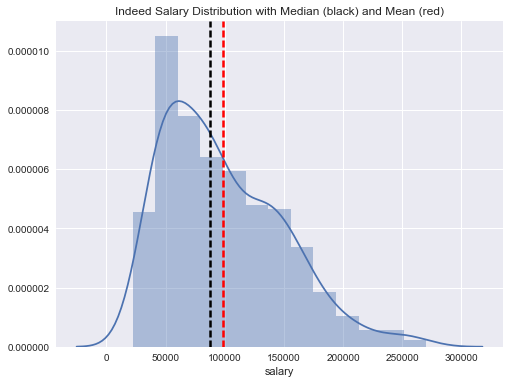

In [26]:
#plotting salary distribution, with vertical lines to represent the mean and median salary
sal_plot = scrape_data[scrape_data["salary"].notnull()]

ax = sns.distplot(sal_plot["salary"])
ax.axvline(sal_plot["salary"].median(), lw=2.5, ls='dashed', color='black')
ax.axvline(sal_plot["salary"].mean(), lw=2.5, ls='dashed', color='red')
sns.plt.title('Indeed Salary Distribution with Median (black) and Mean (red)')

In [27]:
#We'll only be training our model on jobs that have salary data, so separate out salary jobs
salary_data = scrape_data[scrape_data.above_med_sal.notnull()]

#splitting out our predictor variables from the salary data
sal_X = salary_data.iloc[:,0:len(salary_data.columns)-1]
sal_X.reset_index(drop=True, inplace=True)

#sal_y will be above_med_sal, creating as a dataframe, so that I can reset index 
#to match index values of X_dfs to be created in a bit.
sal_y = pd.DataFrame(salary_data["above_med_sal"])

sal_y.reset_index(drop=True, inplace=True)


Importing train-test split on salary data so that I can build and test models before applying them to the unsalaried data.

I'll do a 80:20 split here. We want to stratify the data on the y to make sure the ratio of above/below median
is preserved across train and test sets. Used google random number generator to choose random_state of 74.


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=74) 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Original Model (logistic regression using binary predictor variables)

The first section here utilizes count vectorizers to examine words and phrases most associated with above vs. below median salaries. I then used my observations to create binary variables to indicate if certain powerful words/phrases were represented in a job posting's different columns - marking 1 for yes if present and 0 for no if not present.

I can see how converting some of the "strength" ratios I developed to binary variables would be losing information on the gradient of the influence (e.g., some phrases may be more powerfully associated with above median salaries than others), but given the constraints placed upon completion of this project, I stuck with this approach for the time being.

In [29]:
#initializing count vectorizer to examine text-based data for logistical regression. 
from sklearn.feature_extraction.text import CountVectorizer

#Setting n-gram range from 1-3 is about as complex as I want to get. 
#I also want words that appear in at least 5% of postings, to cut out sparsely 
#represented words that won't have helpful discriminating power
cvec = CountVectorizer(stop_words='english',ngram_range=(1, 3), min_df = .05)


In [30]:
#start by fitting on city name, mostly to look at which city names are most associated with 
#above vs. below med salary.
cvec.fit(X_train["city"])

#transforming city data into city_train
city_train = pd.DataFrame(cvec.transform(X_train["city"]).todense(),
                       columns=cvec.get_feature_names())

city_train.reset_index(drop=True, inplace=True)

In [31]:
#Import and fit our logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

#fitting city_train and y_train to logistic model and testing the initial score.
lr.fit(city_train, y_train)
lr.score(city_train, y_train)

#there's some predictive power here, but it's not great.

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.65181058495821731

In [32]:
#appending y_train to city_train to allow for easier examination of city words 
#associated with above vs. below median salaries
word_observe = pd.concat([city_train, y_train], axis=1)
word_observe.head()

,angeles,austin,chicago,dc,francisco,los,los angeles,new,new york,philadelphia,san,san francisco,seattle,washington,washington dc,york,above_med_sal
0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0


In [33]:
#Observing most common city "words" for both above and below median salaries
#ignore appearance of "above_med_sal" in 1 most common words.
for i in xrange(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print i, "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
    print cw
    print

0 most common words
new york         31.0
york             31.0
new              31.0
seattle          24.0
austin           21.0
los              15.0
los angeles      15.0
angeles          15.0
san               8.0
san francisco     8.0
washington        8.0
francisco         8.0
dc                8.0
chicago           8.0
washington dc     8.0
philadelphia      5.0
above_med_sal     0.0
dtype: float64

1 most common words
above_med_sal    179.0
york              28.0
new               28.0
new york          28.0
san francisco     27.0
san               27.0
francisco         27.0
chicago           24.0
washington        19.0
washington dc     19.0
dc                19.0
los angeles       14.0
los               14.0
angeles           14.0
philadelphia      13.0
austin            10.0
seattle            8.0
dtype: float64



In [34]:
#creating separate lists of the top appearing words so that these can be combined 
#and compared to create ratios of appearances in above median vs. below median salaries
word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)

#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

#creating a "ratio" column to determine frequency of words associated with 
#above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]

word_count_compare.above_below_ratio.sort_values(ascending=False)


above_med_sal         inf
san francisco    3.375000
san              3.375000
francisco        3.375000
chicago          3.000000
philadelphia     2.600000
washington dc    2.375000
washington       2.375000
dc               2.375000
los              0.933333
angeles          0.933333
los angeles      0.933333
new              0.903226
york             0.903226
new york         0.903226
austin           0.476190
seattle          0.333333
Name: above_below_ratio, dtype: float64

Cities most associated with above median salary are Chicago, Washington DC, and San Francisco.  I'll choose these 
three to be represented in my final model, as their ratios of appearance are are greater than 2.0.

In [35]:
#next fit by job title
cvec.fit(X_train["job_title"])

#transforming job_title data into job_train
job_train = pd.DataFrame(cvec.transform(X_train["job_title"]).todense(),
                       columns=cvec.get_feature_names())

In [36]:
#fitting job_train and y_train to logistic model and testing the initial score.
lr.fit(job_train, y_train)
lr.score(job_train, y_train)

0.79944289693593318

Job title seems to be more predictive of median salary information, so there may be more to utilize from this variable.

In [37]:
word_observe = pd.concat([job_train, y_train], axis=1)
word_observe.head()

,analyst,associate,data,data scientist,engineer,learning,machine,machine learning,research,research analyst,scientist,senior,above_med_sal
0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,1,0,1,0,0,0,0,0,0,0,0,0,0.0
2,0,0,1,1,0,0,0,0,0,0,1,0,1.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,1,0,0,0,0,0,0,0,0,0,0,0,0.0


In [38]:
#Observing most common job title "words" for both above and below median salaries

for i in xrange(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print i, "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
    print cw
    print

0 most common words
research            73.0
analyst             63.0
scientist           46.0
data                28.0
research analyst    27.0
associate           17.0
senior              14.0
engineer             6.0
data scientist       4.0
machine learning     1.0
machine              1.0
learning             1.0
above_med_sal        0.0
dtype: float64

1 most common words
above_med_sal       179.0
data                107.0
scientist            97.0
data scientist       78.0
senior               31.0
engineer             25.0
analyst              23.0
learning             21.0
machine learning     18.0
machine              18.0
research             13.0
research analyst      6.0
associate             2.0
dtype: float64



In [39]:
#creating separate lists of the top appearing words so that these can be combined 
#and compared to create ratios of appearances in above median vs. below median salaries

word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)

#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

#creating a "ratio" column to determine frequency of words associated with 
#above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]

word_count_compare.above_below_ratio.sort_values(ascending=False)

above_med_sal             inf
learning            21.000000
data scientist      19.500000
machine learning    18.000000
machine             18.000000
engineer             4.166667
data                 3.821429
senior               2.214286
scientist            2.108696
analyst              0.365079
research analyst     0.222222
research             0.178082
associate            0.117647
Name: above_below_ratio, dtype: float64

Job title terms like "data scientist", combinations of "machine", "learning", "engineer", and "data" all have powerful predictive power for being above the median salary. I'll use these as their ratios are above 3.0.

Job title terms like "research", "analyst" "associate" are all associated with below median income. I'll create a separate "bad title" column to search for these, as their ratios are below 0.5.

In [40]:
#next fit by company name
cvec.fit(X_train["company_name"])

#transforming company name data into company_train
company_train = pd.DataFrame(cvec.transform(X_train["company_name"]).todense(),
                       columns=cvec.get_feature_names())

In [41]:
#fitting company_train and y_train to logistic model and testing the initial score.
lr.fit(company_train, y_train)
lr.score(company_train, y_train)

0.6155988857938719

Company name isn't terribly predictive here, but it is not incredibly surprising, as company names could include a lot of unique words or acronyms that wouldn't necessarily translate to the type of work being done.

In [42]:
word_observe = pd.concat([company_train, y_train], axis=1)
word_observe.head()

,associates,austin,texas,university,university texas,workbridge,workbridge associates,above_med_sal
0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0.0
2,1,0,0,0,0,1,1,1.0
3,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0.0


In [43]:
#Observing most common company "words" for both above and below median salaries

for i in xrange(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print i, "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
    print cw
    print

0 most common words
university               49.0
texas                    13.0
university texas         12.0
austin                   12.0
associates                5.0
above_med_sal             0.0
workbridge associates     0.0
workbridge                0.0
dtype: float64

1 most common words
above_med_sal            179.0
associates                32.0
workbridge associates     21.0
workbridge                21.0
university                 7.0
university texas           6.0
texas                      6.0
austin                     6.0
dtype: float64



In [44]:
#creating separate lists of the top appearing words so that these can be combined 
#and compared to create ratios of appearances in above median vs. below median salaries

word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)

#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

#creating a "ratio" column to determine frequency of words associated with 
#above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]

word_count_compare.above_below_ratio.sort_values(ascending=False)

above_med_sal                 inf
workbridge associates         inf
workbridge                    inf
associates               6.400000
university texas         0.500000
austin                   0.500000
texas                    0.461538
university               0.142857
Name: above_below_ratio, dtype: float64

Working for *presumably* consulting firms (e.g., "associates") is associated with above median salaries, while working for "university" is associated with below median salaries. I can create single variables (one for good - associates; the other for bad - university).

I'm not going to work with location data - I will look at whether or not location matches city name to examine whether a job being in the city it's associated with (or outside of it) has any impact.


In [45]:
#next fit by job summary
cvec.fit(X_train["summary"])

#transforming location name data into location_train
summary_train = pd.DataFrame(cvec.transform(X_train["summary"]).todense(),
                       columns=cvec.get_feature_names())

In [46]:
#fitting summary_train and y_train to logistic model and testing the initial score.
lr.fit(summary_train, y_train)
lr.score(summary_train, y_train)

#quite a bit of predictive power here.  This should be ripe for exploration

0.81058495821727017

In [47]:
word_observe = pd.concat([summary_train, y_train], axis=1)
word_observe.head()

,analysis,analyst,analytics,analyze,big,big data,client,company,data,data analysis,...,seeking,senior,software,statistical,team,techniques,work,working,years,above_med_sal
0,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,1.0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,1.0
3,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0


In [48]:
#Observing most common summary "words" for both above and below median salaries

for i in xrange(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print i, "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
    print cw
    print

0 most common words
data               286.0
research            46.0
analysis            43.0
scientist           38.0
experience          36.0
scientists          21.0
data analysis       20.0
management          18.0
analyze             16.0
including           14.0
work                14.0
analyst             14.0
team                13.0
statistical         13.0
results             13.0
experience data     12.0
seeking              9.0
techniques           9.0
new                  8.0
working              8.0
dtype: float64

1 most common words
data                325.0
above_med_sal       179.0
scientist           107.0
data scientist       97.0
experience           48.0
team                 47.0
scientists           37.0
looking              35.0
data scientists      34.0
analytics            27.0
learning             27.0
senior               26.0
machine learning     25.0
machine              25.0
big                  23.0
big data             23.0
science              21.0
da

In [49]:
#creating separate lists of the top appearing words so that these can be combined 
#and compared to create ratios of appearances in above median vs. below median salaries

word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)

#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

#creating a "ratio" column to determine frequency of words associated with above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]

word_count_compare.above_below_ratio.sort_values(ascending=False)

above_med_sal             inf
data scientist      16.166667
learning            13.500000
senior              13.000000
machine learning    12.500000
machine             12.500000
looking              8.750000
data science         6.666667
big                  5.750000
big data             5.750000
company              5.000000
data scientists      4.857143
analytics            3.857143
client               3.750000
team                 3.615385
science              3.500000
years                3.200000
scientist            2.815789
software             2.333333
new                  2.000000
scientists           1.761905
working              1.625000
experience           1.333333
seeking              1.222222
data                 1.136364
work                 1.071429
techniques           1.000000
statistical          1.000000
analyst              0.857143
experience data      0.583333
data analysis        0.450000
including            0.428571
analysis             0.395349
management

Job summary terms including "machine learning", "machine", "learning", "data scientist", "data science", "senior", "lead", "big data", "analytics", "years" (presumably looking for at least so many years) are all associated with above median salaries.  It's odd to see a word like "looking" at the top of this list. Despite its presence, I'm reluctant to include "looking" in my binary variable for predictive purposes.

"Research", "analyze" and "analysis" are all associated with below median salaries.


In [50]:
#next fit by original salary period
cvec.fit(X_train["og_salary_period"])

#transforming location name data into location_train
og_salary_period_train = pd.DataFrame(cvec.transform(X_train["og_salary_period"]).todense(),
                       columns=cvec.get_feature_names())

In [51]:
#fitting city_train and y_train to logistic model and testing the initial score.
lr.fit(og_salary_period_train, y_train)
lr.score(og_salary_period_train, y_train)

0.63509749303621166

Salary period has some predictive power - not much, and this is more for curiousity's sake, as this variable will not be present when attempting to predict salaries of jobs without salary information.

In [52]:
word_observe = pd.concat([og_salary_period_train, y_train], axis=1)
word_observe.head()

,hour,month,year,above_med_sal
0,0,0,1,1.0
1,1,0,0,0.0
2,0,0,1,1.0
3,0,1,0,0.0
4,0,0,1,0.0


In [53]:
#Observing most common salary "words" for both above and below median salaries

for i in xrange(2):
    word_count = word_observe[word_observe["above_med_sal"]==i].sum(axis=0)
    print i, "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
    print cw
    print

0 most common words
year             105.0
hour              39.0
month             34.0
above_med_sal      0.0
dtype: float64

1 most common words
above_med_sal    179.0
year             153.0
hour              20.0
month              6.0
dtype: float64



In [54]:
#creating separate lists of the top appearing words so that these can be combined 
#and compared to create ratios of appearances in above median vs. below median salaries

word_count_below = word_observe[word_observe["above_med_sal"]==0].sum(axis=0)
word_count_above = word_observe[word_observe["above_med_sal"]==1].sum(axis=0)

#creating as dataframe, using method ".T" to transpose columns with index.
word_count_compare = pd.DataFrame([word_count_below, word_count_above]).T

#creating a "ratio" column to determine frequency of words associated with 
#above median jobs vs. below median jobs
word_count_compare["above_below_ratio"] = word_count_compare[1]/word_count_compare[0]

word_count_compare.above_below_ratio.sort_values(ascending=False)


above_med_sal         inf
year             1.457143
hour             0.512821
month            0.176471
Name: above_below_ratio, dtype: float64

Yearly salaries are most associated with above median salaries, while monthly salaries are most associated with below median salaries - however, this is a useless variable for model building, because none of the postings without salary data will say whether salaries are yearly, monthly, etc.

## Collection of Findings:

####  - cities most associated with above median salary are Chicago, Washington DC, and San Francisco

#### - job title terms like "data scientist", combinations of "machine", "learning", "engineer", and "data"  all have powerful predictive power for being above the median salary

#### - job_title terms like "research", "analyst" "associate" are all associated with below median income

#### - working for *presumably* consulting firms e.g., "associates" is associated with above median salaries, while working for "university" is associated with below median salaries.

#### - I'm not going to work with location data - I will look at whether or not location matches city name to examine whether a job being in the city it's associated with (or outside of it) has any impact.

#### - job summary terms including "machine learning", "machine", "learning", "data scientist", "data science", "senior", "lead", "big data", "analytics", "years" (presumably looking for at least so many years) are all associated with above median salaries

#### - "research", "analyze" and "analysis" are all associated with below median salaries


### Adding columns to sal_X to test predictive value of insights above. 

#### Once columns are added, I will redo the train-test split (using the same parameters above). It's just easier to do it all here one time rather than separately for X_train and X_test, etc.


In [55]:
#Creating eight binary variables utilizing insights above to prepare data for logistic regression

#splitting out our predictor variables from the salary data
sal_X = salary_data[["city", "job_title", "company_name", "location", "summary", "og_salary_period"]]
sal_X.reset_index(drop=True, inplace=True)

#sal_y will be above_med_sal, creating as a dataframe, then converting to a 
#1-D array to allow for easier use below with k-folds, etc.
sal_y = pd.DataFrame(salary_data["above_med_sal"])
sal_y = pd.DataFrame.as_matrix(sal_y).ravel()


#Creating variable for if city is chi, DC, or sf
sal_X["is_chi_dc_sf"] = 0

sal_X.ix[(sal_X["city"].str.contains("chicago") | 
          sal_X["city"].str.contains("washington dc") | 
          sal_X["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


#Creating variable for if job title includes "data scientist", combinations of 
#"machine", "learning", "engineer", and "data"
sal_X["good_job_title"] = 0

sal_X.ix[(sal_X["job_title"].str.contains("data scientist") | 
            sal_X["job_title"].str.contains("machine") | 
            sal_X["job_title"].str.contains("learning") |
            sal_X["job_title"].str.contains("engineer") |
            sal_X["job_title"].str.contains("data")), "good_job_title"] = 1


# job_title terms like "research", "analyst" "associate" are all associated with below median income
sal_X["bad_job_title"] = 0

sal_X.ix[(sal_X["job_title"].str.contains("research") | 
            sal_X["job_title"].str.contains("analyst") | 
            sal_X["job_title"].str.contains("associate")), "bad_job_title"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated 
#with above median salaries, while working for "university" is associated with below median salaries.

sal_X["good_company"] = 0

sal_X.ix[(sal_X["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

sal_X["bad_company"] = 0

sal_X.ix[(sal_X["company_name"].str.contains("university") ), "bad_company"] = 1


# For location data - I will look at whether or not location matches city name to examine whether
# a job being in the city it's associated with (or outside of it) has any impact.

sal_X["in_city"] = 0

sal_X.ix[(sal_X["location"].str.contains("new york") |
            sal_X["location"].str.contains("seattle") |
            sal_X["location"].str.contains("san francisco") |
            sal_X["location"].str.contains("houston") |
            sal_X["location"].str.contains("denver") |
            sal_X["location"].str.contains("austin") |
            sal_X["location"].str.contains("washington dc") |
            sal_X["location"].str.contains("miami") |
            sal_X["location"].str.contains("phoenix") |
            sal_X["location"].str.contains("pittsburgh") |
            sal_X["location"].str.contains("portland") |
            sal_X["location"].str.contains("philadelphia") |
            sal_X["location"].str.contains("boulder") |
            sal_X["location"].str.contains("dallas") |
            sal_X["location"].str.contains("los angeles") |
            sal_X["location"].str.contains("atlanta") |
            sal_X["location"].str.contains("chicago")), "in_city"] = 1


# job summary terms including "machine learning", "machine", "learning", "data scientist",
# "data science", "senior", "lead", "big data", "analytics", "years" 
#(presumably looking for at least so many years) are all associated with above median salaries

sal_X["good_summary"] = 0

sal_X.ix[(sal_X["summary"].str.contains("machine") | 
            sal_X["summary"].str.contains("learning") | 
            sal_X["summary"].str.contains("data scien") |
            sal_X["summary"].str.contains("senior") |
            sal_X["summary"].str.contains("lead") |
            sal_X["summary"].str.contains("big data") |         
            sal_X["summary"].str.contains("analytics") |
            sal_X["summary"].str.contains("years")), "good_summary"] = 1


# "research", "analyze" and "analysis" are all associated with below median salaries

sal_X["bad_summary"] = 0

sal_X.ix[(sal_X["summary"].str.contains("research") | 
            sal_X["summary"].str.contains("analyze") | 
            sal_X["summary"].str.contains("analysis")), "bad_summary"] = 1

#dropping original data columns from sal_X to make analysis easier.
sal_X.drop(["city", "job_title", "company_name", "location", "summary", "og_salary_period"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
sal_X = sal_X.astype("float")

sal_X.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,is_chi_dc_sf,good_job_title,bad_job_title,good_company,bad_company,in_city,good_summary,bad_summary
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


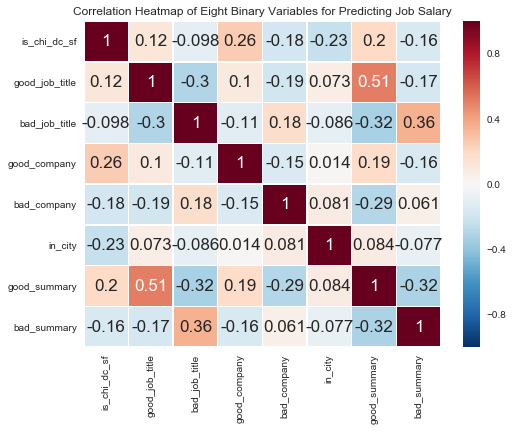

In [56]:
# Doing a quick correlation matrix to examine relationships between my variables:

# Perform Pearson correlation coefficients using Numpy
feature_correlation_matrix = sal_X.corr()

#Creating heatmap correlation matrix of predictor coefficients.
sns.heatmap(feature_correlation_matrix,
           annot = True,
           linewidths = 0.5)
sns.plt.title('Correlation Heatmap of Eight Binary Variables for Predicting Job Salary')
#pretty solid separation of the predictive variables.

Conducting train-test split on salary data so that I can build and test models before applying them to the unsalaried
data.

I'll do a 80:20 split here. We want to stratify the data on the y to make sure the ratio of above/below median
is preserved across train and test sets. Used google random number generator to choose random_state of 74.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=74) 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)


In [58]:
#printing relative make-ups of each of the new variables to ensure they are not too heavily represented among all jobs
print("counts of 'is_chi_dc_sf: ") 
print(X_train["is_chi_dc_sf"].value_counts())
print
print("counts of 'good_job_title: ")
print(X_train["good_job_title"].value_counts())
print
print("counts of 'bad_job_title: ")
print(X_train["bad_job_title"].value_counts())
print
print("counts of 'good_company: ")
print(X_train["good_company"].value_counts())
print
print("counts of 'bad_company: ")
print(X_train["bad_company"].value_counts())
print
print("counts of 'in_city: ")
print(X_train["in_city"].value_counts())
print
print("counts of 'good_summary: ")
print(X_train["good_summary"].value_counts())
print
print("counts of 'bad_summary: ")
print(X_train["bad_summary"].value_counts())


counts of 'is_chi_dc_sf: 
0.0    265
1.0     94
Name: is_chi_dc_sf, dtype: int64

counts of 'good_job_title: 
0.0    187
1.0    172
Name: good_job_title, dtype: int64

counts of 'bad_job_title: 
0.0    230
1.0    129
Name: bad_job_title, dtype: int64

counts of 'good_company: 
0.0    322
1.0     37
Name: good_company, dtype: int64

counts of 'bad_company: 
0.0    303
1.0     56
Name: bad_company, dtype: int64

counts of 'in_city: 
1.0    253
0.0    106
Name: in_city, dtype: int64

counts of 'good_summary: 
0.0    195
1.0    164
Name: good_summary, dtype: int64

counts of 'bad_summary: 
0.0    245
1.0    114
Name: bad_summary, dtype: int64


Good_company and bad_company are the two most unevenly distributed of the variables.  I can keep this in mind should  I be looking to remove any of these variables from future consideration.

In [59]:
#now score a logistic regression on X_train and y_train using cross_val_scores
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print "Score:", logreg.score(X_train, y_train)     #default metric of score is R-squared

scores = cross_val_score(logreg, X_train, y_train, cv=6)
print "Cross-validated scores:", scores

print "Model coefficients: ", logreg.coef_


Score: 0.827298050139
Cross-validated scores: [ 0.78333333  0.78333333  0.88333333  0.76666667  0.81666667  0.93220339]
Model coefficients:  [[ 1.23852909  1.35361507 -0.89367635  1.00641074 -1.13933333  0.75526444
   1.26111214 -0.48255553]]


All things considered, the model has considerable predictive power with only eight variables, at least based on the   
train set - I'm quite happy with this.

In [60]:
# Predicting salaries in X_test given predictors developed with X_train

y_probs = logreg.predict(X_test)   #generates predicted values of Y_test from X_test based off of training set.

print "Score:", logreg.score(X_test, y_test)

#Create classification and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Actual values are rows (0, 1), while predicted are columns (0, 1); 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
#precision is true positives / (true positives + false positives) - of all predicted, % correct
#recall is true positives / (true positives + false negatives) - of all actual, % correct
#f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
#support is number of true values for each class
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))


Score: 0.833333333333
[[40  5]
 [10 35]]
             precision    recall  f1-score   support

  below_med       0.80      0.89      0.84        45
  above_med       0.88      0.78      0.82        45

avg / total       0.84      0.83      0.83        90



#### The initial model has an accuracy score of 83% utiliizing only eight binary variables, which I'm quite happy with. It struggles the most with recall of above_med jobs.  Of all above median jobs, it only correctly predicted 76% of them

### Applying the first model to predict above vs. below median salary in jobs without salary data.

In [64]:
#First, I need to prepare all of the unsalaried data in the same way I prepared my train_test data
predict_data = scrape_data[scrape_data.above_med_sal.isnull()]
predict_data.reset_index(drop=True, inplace=True)

#splitting out our predictor variables from the salary data
predict_X = predict_data[["city", "job_title", "company_name", "location", "summary"]]
predict_X.reset_index(drop=True, inplace=True)
predict_X.head()

,city,job_title,company_name,location,summary
0,new york,data scientist big data analytics,kpmg,new york ny,kpmg is currently seeking a data scientist b...
1,new york,people analytics research data scientist,blackrock,new york ny,we are looking for a data scientist with advan...
2,new york,data scientist,kpmg,new york ny,kpmg is currently seeking a data scientist to ...
3,new york,data scientist,pulsepoint,new york ny,3 years of full time experience working as a...
4,new york,data scientist,massmutual financial group,new york ny,massmutual’s advanced analytics group is seek...


In [65]:
#Adding eight binary variables utilizing insights above to prepare data for logistic regression
#Creating variable for if city is chi, DC, or sf
predict_X["is_chi_dc_sf"] = 0

predict_X.ix[(predict_X["city"].str.contains("chicago") | 
          predict_X["city"].str.contains("washington dc") | 
          predict_X["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


#Creating variable for if job title includes "data scientist", combinations of 
#"machine", "learning", "engineer", and "data"
predict_X["good_job_title"] = 0

predict_X.ix[(predict_X["job_title"].str.contains("data scientist") | 
            predict_X["job_title"].str.contains("machine") | 
            predict_X["job_title"].str.contains("learning") |
            predict_X["job_title"].str.contains("engineer") |
            predict_X["job_title"].str.contains("data")), "good_job_title"] = 1


# job_title terms like "research", "analyst" "associate" are all associated with below median income
predict_X["bad_job_title"] = 0

predict_X.ix[(predict_X["job_title"].str.contains("research") | 
            predict_X["job_title"].str.contains("analyst") | 
            predict_X["job_title"].str.contains("associate")), "bad_job_title"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

predict_X["good_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

predict_X["bad_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("university") ), "bad_company"] = 1


# For location data - I will look at whether or not location matches city name to examine whether
# a job being in the city it's associated with (or outside of it) has any impact.

predict_X["in_city"] = 0

predict_X.ix[(predict_X["location"].str.contains("new york") |
            predict_X["location"].str.contains("seattle") |
            predict_X["location"].str.contains("san francisco") |
            predict_X["location"].str.contains("houston") |
            predict_X["location"].str.contains("denver") |
            predict_X["location"].str.contains("austin") |
            predict_X["location"].str.contains("washington dc") |
            predict_X["location"].str.contains("miami") |
            predict_X["location"].str.contains("phoenix") |
            predict_X["location"].str.contains("pittsburgh") |
            predict_X["location"].str.contains("portland") |
            predict_X["location"].str.contains("philadelphia") |
            predict_X["location"].str.contains("boulder") |
            predict_X["location"].str.contains("dallas") |
            predict_X["location"].str.contains("los angeles") |
            predict_X["location"].str.contains("atlanta") |
            predict_X["location"].str.contains("chicago")), "in_city"] = 1


# job summary terms including "machine learning", "machine", "learning", "data scientist",
# "data science", "senior", "lead", "big data", "analytics", "years" 
#(presumably looking for at least so many years) are all associated with above median salaries

predict_X["good_summary"] = 0

predict_X.ix[(predict_X["summary"].str.contains("machine") | 
            predict_X["summary"].str.contains("learning") | 
            predict_X["summary"].str.contains("data scien") |
            predict_X["summary"].str.contains("senior") |
            predict_X["summary"].str.contains("lead") |
            predict_X["summary"].str.contains("big data") |         
            predict_X["summary"].str.contains("analytics") |
            predict_X["summary"].str.contains("years")), "good_summary"] = 1


# "research", "analyze" and "analysis" are all associated with below median salaries

predict_X["bad_summary"] = 0

predict_X.ix[(predict_X["summary"].str.contains("research") | 
            predict_X["summary"].str.contains("analyze") | 
            predict_X["summary"].str.contains("analysis")), "bad_summary"] = 1


#dropping original data columns from sal_X to make analysis easier.
predict_X.drop(["city", "job_title", "company_name", "location", "summary"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
predict_X = predict_X.astype("float")

predict_X.head()


/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,is_chi_dc_sf,good_job_title,bad_job_title,good_company,bad_company,in_city,good_summary,bad_summary
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [66]:
#generating median salary predictions for unsalaried job postings
predict_y = logreg.predict(predict_X)   #generates predicted values of Y_test from X_test based off of training set.
predict_data["salary_prediction"] = predict_y
predict_data.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,city,job_title,company_name,location,summary,salary,og_salary_period,above_med_sal,salary_prediction
0,new york,data scientist big data analytics,kpmg,new york ny,kpmg is currently seeking a data scientist b...,NaN,NaN,NaN,1.0
1,new york,people analytics research data scientist,blackrock,new york ny,we are looking for a data scientist with advan...,NaN,NaN,NaN,1.0
2,new york,data scientist,kpmg,new york ny,kpmg is currently seeking a data scientist to ...,NaN,NaN,NaN,1.0
3,new york,data scientist,pulsepoint,new york ny,3 years of full time experience working as a...,NaN,NaN,NaN,1.0
4,new york,data scientist,massmutual financial group,new york ny,massmutual’s advanced analytics group is seek...,NaN,NaN,NaN,1.0


In [67]:
predict_data.salary_prediction.value_counts()

0.0    3128
1.0    2822
Name: salary_prediction, dtype: int64

In [68]:
predict_data.groupby(["city", "salary_prediction"]).salary_prediction.count()

city           salary_prediction
atlanta        0.0                  137
               1.0                  105
austin         0.0                   57
               1.0                   93
boulder        0.0                  143
               1.0                  114
chicago        0.0                  127
               1.0                  261
dallas         0.0                  115
               1.0                   96
denver         0.0                  191
               1.0                  125
houston        0.0                  106
               1.0                   38
los angeles    0.0                  329
               1.0                  178
miami          0.0                   95
               1.0                   11
new york       0.0                  385
               1.0                  333
philadelphia   0.0                  354
               1.0                   85
phoenix        0.0                   53
               1.0                   37
pittsbu

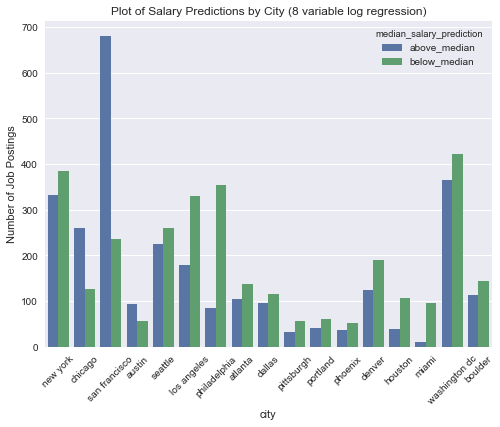

In [69]:
city_predictions = pd.DataFrame(predict_data[["city", "salary_prediction"]])

city_predictions['median_salary_prediction'] = city_predictions.salary_prediction.map({0:"below_median", 1:"above_median"})

sns.countplot(x="city", hue="median_salary_prediction", data=city_predictions)
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
sns.plt.title('Plot of Salary Predictions by City (8 variable log regression)')
plt.show()

### Of 5950 job postings without salary information listed, my first eight-feature logistic model predicts 3,128 (52%) as being below the median, while predicting 2,822 (48%) as being above the median.  San Francisco is predicted to be the biggest hub of above_median salary jobs (unsurprisingly)

### Second Model - using tf-idf for job title and summary data

In [70]:
#importing tf_idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
#I need to reset my data here, as this process requires the 
#original job posting data to undergo it's processing.

#splitting out our predictor variables from the salary data
sal_X = salary_data[["city", "job_title", "company_name", "location", "summary", "og_salary_period"]]
sal_X.reset_index(drop=True, inplace=True)

#sal_y will be above_med_sal, creating as a dataframe, so that I can reset index 
#to match index values of X_dfs to be created in a bit.
sal_y = pd.DataFrame(salary_data["above_med_sal"])

sal_y.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=74) 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [72]:
#I want to train one vectorizer on job title data, and another on summary.

#I want features that appear in at least 2.5% of job titles, we'll start with a maximum 
#of 15 features, with an n-gram range of 1-2

tvec_title = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=0.025, max_features=15)

tvec_title.fit(X_train["job_title"])

job_train = pd.DataFrame(tvec_title.transform(X_train["job_title"]).todense(),
                       columns=tvec_title.get_feature_names())

# Which words appear the most.
word_counts = job_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(15)

scientist           77.249528
data                75.553653
analyst             53.147636
research            49.977121
data scientist      49.861350
senior              30.574503
research analyst    22.092099
engineer            20.491248
associate           13.302941
learning            12.625356
statistical         12.460446
software            10.988497
machine learning     9.984033
machine              9.984033
engineering          9.197923
dtype: float64

In [73]:
#testing effectiveness of tvec on test data
job_test = pd.DataFrame(tvec_title.transform(X_test["job_title"]).todense(),
                       columns=tvec_title.get_feature_names())

logreg = LogisticRegression()
logreg.fit(job_train, y_train)

print(logreg.score(job_test, y_test))

#quite effective.  I'm happy keeping number of features restricted to 15 here.

y_probs = logreg.predict(job_test)   #generates predicted values of Y_test from X_test based off of training set.

#Create classification and confusion matrix
# Actual values are rows (0, 1), while predicted are columns (0, 1); 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
#precision is true positives / (true positives + false positives) - of all predicted, % correct
#recall is true positives / (true positives + false negatives) - of all actual, % correct
#f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
#support is number of true values for each class
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))


#job title alone has pretty good predictive power when utilizing tf-idf.

0.777777777778
[[42  3]
 [17 28]]
             precision    recall  f1-score   support

  below_med       0.71      0.93      0.81        45
  above_med       0.90      0.62      0.74        45

avg / total       0.81      0.78      0.77        90



In [74]:
#initiating new tvec for job summary - we'll still preserve the max features at 15, 
#with an n-gram range of 1-3
tvec_sum = TfidfVectorizer(stop_words="english", ngram_range=(1, 3), min_df=0.025, max_features=15)

tvec_sum.fit(X_train["summary"])

summary_train = pd.DataFrame(tvec_sum.transform(X_train["summary"]).todense(),
                       columns=tvec_sum.get_feature_names())

# Which words appear the most.
word_counts = summary_train.sum(axis=0)
word_counts.sort_values(ascending = False).head()

data              167.123629
scientist          54.373393
experience         40.504931
data scientist     37.964226
research           33.406640
dtype: float64

In [75]:
#testing effectiveness of tvec on test data
summary_test = pd.DataFrame(tvec_sum.transform(X_test["summary"]).todense(),
                       columns=tvec_sum.get_feature_names())

logreg = LogisticRegression()
logreg.fit(summary_train, y_train)

print(logreg.score(summary_test, y_test))

#quite effective.  I'm happy keeping number of features restricted to 15 here.

y_probs = logreg.predict(summary_test)   #generates predicted values of Y_test from X_test based off of training set.

#Create classification and confusion matrix
# Actual values are rows (0, 1), while predicted are columns (0, 1); 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
#precision is true positives / (true positives + false positives) - of all predicted, % correct
#recall is true positives / (true positives + false negatives) - of all actual, % correct
#f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
#support is number of true values for each class
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))


0.655555555556
[[38  7]
 [24 21]]
             precision    recall  f1-score   support

  below_med       0.61      0.84      0.71        45
  above_med       0.75      0.47      0.58        45

avg / total       0.68      0.66      0.64        90



In [76]:
#now, appending job_train and summary_train to X_train, and adding binary columns 
#for is_chi_dc_sf, in_city, good_company, and bad_company before performing logistic regression 

#Preparing X_train 

#Creating variable for if city is chi, DC, or sf
X_train["is_chi_dc_sf"] = 0

X_train.ix[(X_train["city"].str.contains("chicago") | 
            X_train["city"].str.contains("washington dc") | 
             X_train["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

X_train["good_company"] = 0

X_train.ix[(X_train["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

X_train["bad_company"] = 0

X_train.ix[(X_train["company_name"].str.contains("university") ), "bad_company"] = 1


# I'm not going to work with location data - I will look at whether or not location 
#matches city name to examine whether a job being in the city it's associated with 
#(or outside of it) has any impact.

X_train["in_city"] = 0

X_train.ix[(X_train["location"].str.contains("new york") |
            X_train["location"].str.contains("seattle") |
            X_train["location"].str.contains("san francisco") |
            X_train["location"].str.contains("houston") |
            X_train["location"].str.contains("denver") |
            X_train["location"].str.contains("austin") |
            X_train["location"].str.contains("washington dc") |
            X_train["location"].str.contains("miami") |
            X_train["location"].str.contains("phoenix") |
            X_train["location"].str.contains("pittsburgh") |
            X_train["location"].str.contains("portland") |
            X_train["location"].str.contains("philadelphia") |
            X_train["location"].str.contains("boulder") |
            X_train["location"].str.contains("dallas") |
            X_train["location"].str.contains("los angeles") |
            X_train["location"].str.contains("atlanta") |
            X_train["location"].str.contains("chicago")), "in_city"] = 1


X_train = pd.concat([X_train, job_train, summary_train], axis=1)

X_train.drop(["city", "job_title", "company_name", "location", "summary", "og_salary_period"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
X_train = X_train.astype("float")

X_train.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,is_chi_dc_sf,good_company,bad_company,in_city,analyst,associate,data,data scientist,engineer,engineering,...,data scientists,experience,learning,looking,research,scientist,scientists,senior,team,work
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.772139,0.0,0.635453,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.000000,0.0,0.540729,0.663443,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.544987,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.510701,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [77]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print "Score:", logreg.score(X_train, y_train) 

#to get cross_val score to work properly I had to convert it to a single-dimension array in order for it to work, 
#via the following code.

y_train = pd.DataFrame.as_matrix(y_train).ravel()

scores = cross_val_score(logreg, X_train, y_train, cv=6)
print "Cross-validated scores:", scores


Score: 0.838440111421
Cross-validated scores: [ 0.78333333  0.76666667  0.86666667  0.81666667  0.83333333  0.83050847]


In [78]:
#now, appending job_test and summary_test to X_test, and adding binary columns for 
#is_chi_dc_sf, in_city, good_company, and bad_company before performing logistic regression 

#Preparing X_test given columns generated for X_train

#Creating variable for if city is chi, DC, or sf
X_test["is_chi_dc_sf"] = 0

X_test.ix[(X_test["city"].str.contains("chicago") | 
            X_test["city"].str.contains("washington dc") | 
             X_test["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

X_test["good_company"] = 0

X_test.ix[(X_test["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

X_test["bad_company"] = 0

X_test.ix[(X_test["company_name"].str.contains("university") ), "bad_company"] = 1


# I'm not going to work with location data - I will look at whether or not location matches 
#city name to examine whether a job being in the city it's associated with 
#(or outside of it) has any impact.

X_test["in_city"] = 0

X_test.ix[(X_test["location"].str.contains("new york") |
            X_test["location"].str.contains("seattle") |
            X_test["location"].str.contains("san francisco") |
            X_test["location"].str.contains("houston") |
            X_test["location"].str.contains("denver") |
            X_test["location"].str.contains("austin") |
            X_test["location"].str.contains("washington dc") |
            X_test["location"].str.contains("miami") |
            X_test["location"].str.contains("phoenix") |
            X_test["location"].str.contains("pittsburgh") |
            X_test["location"].str.contains("portland") |
            X_test["location"].str.contains("philadelphia") |
            X_test["location"].str.contains("boulder") |
            X_test["location"].str.contains("dallas") |
            X_test["location"].str.contains("los angeles") |
            X_test["location"].str.contains("atlanta") |
            X_test["location"].str.contains("chicago")), "in_city"] = 1


X_test = pd.concat([X_test, job_test, summary_test], axis=1)

X_test.drop(["city", "job_title", "company_name", "location", "summary", "og_salary_period"], axis=1, inplace=True)

X_test.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,is_chi_dc_sf,good_company,bad_company,in_city,analyst,associate,data,data scientist,engineer,engineering,...,data scientists,experience,learning,looking,research,scientist,scientists,senior,team,work
0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0,0,1,1,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0,0,1,1,0.505708,0.0,0.0,0.0,0.0,0.0,...,0.0,0.745268,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0,1,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.767666,0.568886,0.0,0.0,0.0,0.0


In [79]:
# Predicting salaries in X_test given predictors developed with X_train

y_probs = logreg.predict(X_test)   #generates predicted values of Y_test from X_test based off of training set.

print "Score:", logreg.score(X_test, y_test)     #default metric of score is R-squared
#scores will differ between different instances of generating test sets due to randomness of set selection.

#Create classification and confusion matrix
# Actual values are rows (0, 1), while predicted are columns (0, 1); 
print(confusion_matrix(y_test, y_probs,))

#printing classification report
#precision is true positives / (true positives + false positives) - of all predicted, % correct
#recall is true positives / (true positives + false negatives) - of all actual, % correct
#f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
#support is number of true values for each class
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))


Score: 0.733333333333
[[35 10]
 [14 31]]
             precision    recall  f1-score   support

  below_med       0.71      0.78      0.74        45
  above_med       0.76      0.69      0.72        45

avg / total       0.74      0.73      0.73        90



The second model, has a worse predictive accuracy of 73%. Given the total number of features involved, and the better performance I'm inclinded to prefer the eight binary feature logistic model developed above.

### Applying the second model to predict above vs. below median salary in jobs without salary data.

In [82]:
#First, I need to prepare all of the unsalaried data in the same way I prepared my train_test data
predict_data = scrape_data[scrape_data.above_med_sal.isnull()]
predict_data.reset_index(drop=True, inplace=True)

#splitting out our predictor variables from the salary data
predict_X = predict_data[["city", "job_title", "company_name", "location", "summary"]]
predict_X.reset_index(drop=True, inplace=True)
predict_X.head()

,city,job_title,company_name,location,summary
0,new york,data scientist big data analytics,kpmg,new york ny,kpmg is currently seeking a data scientist b...
1,new york,people analytics research data scientist,blackrock,new york ny,we are looking for a data scientist with advan...
2,new york,data scientist,kpmg,new york ny,kpmg is currently seeking a data scientist to ...
3,new york,data scientist,pulsepoint,new york ny,3 years of full time experience working as a...
4,new york,data scientist,massmutual financial group,new york ny,massmutual’s advanced analytics group is seek...


In [83]:
#applying tf-idf for job title and summary 
job_predict_X = pd.DataFrame(tvec_title.transform(predict_X["job_title"]).todense(),
                       columns=tvec_title.get_feature_names())

summary_predict_X = pd.DataFrame(tvec_sum.transform(predict_X["summary"]).todense(),
                       columns=tvec_sum.get_feature_names())

#now, appending job_test and summary_test to X_test, and adding binary columns 
#for is_chi_dc_sf, in_city, good_company, and bad_company before performing logistic regression 

#Preparing X_test given columns generated for X_train

#Creating variable for if city is chi, DC, or sf
predict_X["is_chi_dc_sf"] = 0

predict_X.ix[(predict_X["city"].str.contains("chicago") | 
            predict_X["city"].str.contains("washington dc") | 
             predict_X["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

predict_X["good_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

predict_X["bad_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("university") ), "bad_company"] = 1


# I'm not going to work with location data - I will look at whether or not location 
#matches city name to examine whether a job being in the city it's associated with 
#(or outside of it) has any impact.

predict_X["in_city"] = 0

predict_X.ix[(predict_X["location"].str.contains("new york") |
            predict_X["location"].str.contains("seattle") |
            predict_X["location"].str.contains("san francisco") |
            predict_X["location"].str.contains("houston") |
            predict_X["location"].str.contains("denver") |
            predict_X["location"].str.contains("austin") |
            predict_X["location"].str.contains("washington dc") |
            predict_X["location"].str.contains("miami") |
            predict_X["location"].str.contains("phoenix") |
            predict_X["location"].str.contains("pittsburgh") |
            predict_X["location"].str.contains("portland") |
            predict_X["location"].str.contains("philadelphia") |
            predict_X["location"].str.contains("boulder") |
            predict_X["location"].str.contains("dallas") |
            predict_X["location"].str.contains("los angeles") |
            predict_X["location"].str.contains("atlanta") |
            predict_X["location"].str.contains("chicago")), "in_city"] = 1


predict_X = pd.concat([predict_X, job_predict_X, summary_predict_X], axis=1)

predict_X.drop(["city", "job_title", "company_name", "location", "summary", "og_salary_period"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
predict_X = predict_X.astype("float")

predict_X.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,is_chi_dc_sf,good_company,bad_company,in_city,analyst,associate,data,data scientist,engineer,engineering,...,data scientists,experience,learning,looking,research,scientist,scientists,senior,team,work
0,0.0,0.0,0.0,1.0,0.0,0.0,0.789330,0.484231,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.267193,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.450583,0.552839,0.0,0.0,...,0.0,0.000000,0.0,0.629361,0.0,0.423516,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.540729,0.663443,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.334849,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.540729,0.663443,0.0,0.0,...,0.0,0.471138,0.0,0.000000,0.0,0.406350,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.540729,0.663443,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.452508,0.0,0.0,0.0,0.0


In [84]:
predict_y = logreg.predict(predict_X)   #generates predicted values of Y_test from X_test based off of training set.
predict_data["salary_prediction"] = predict_y
predict_data.head()

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,city,job_title,company_name,location,summary,salary,og_salary_period,above_med_sal,salary_prediction
0,new york,data scientist big data analytics,kpmg,new york ny,kpmg is currently seeking a data scientist b...,NaN,NaN,NaN,1.0
1,new york,people analytics research data scientist,blackrock,new york ny,we are looking for a data scientist with advan...,NaN,NaN,NaN,1.0
2,new york,data scientist,kpmg,new york ny,kpmg is currently seeking a data scientist to ...,NaN,NaN,NaN,1.0
3,new york,data scientist,pulsepoint,new york ny,3 years of full time experience working as a...,NaN,NaN,NaN,1.0
4,new york,data scientist,massmutual financial group,new york ny,massmutual’s advanced analytics group is seek...,NaN,NaN,NaN,1.0


In [86]:
predict_data.salary_prediction.value_counts()

0.0    3114
1.0    2836
Name: salary_prediction, dtype: int64

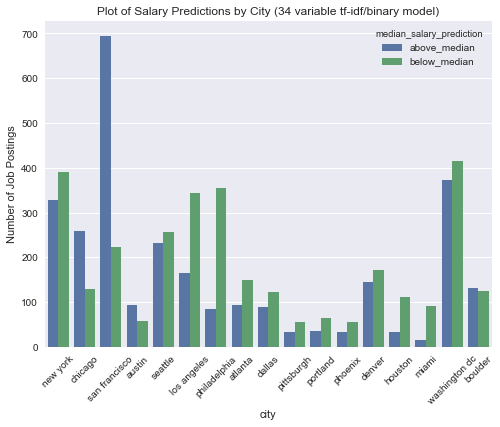

In [87]:
city_predictions = pd.DataFrame(predict_data[["city", "salary_prediction"]])

city_predictions['median_salary_prediction'] = city_predictions.salary_prediction.map({0:"below_median", 1:"above_median"})

sns.countplot(x="city", hue="median_salary_prediction", data=city_predictions)
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
sns.plt.title('Plot of Salary Predictions by City (34 variable tf-idf/binary model)')
plt.show()


### Of 5950 job postings without salary information listed, my first 34 feature tf-idf logistic model predicts 3,144 (52%) as being below the median, while predicting 2,836 (48%) as being above the median.  San Francisco is predicted to be the biggest hub of above_median salary jobs (unsurprisingly)

#### Thought experiment: What is the baseline accuracy for this model?

Of the two models I built, there isn't a great difference in terms of their predictive power. Using eight binary features in my first logistic regression model, I had 82% accuracy in predicting above vs. below median salaries in my test set.  Using 54 features in my NLP model, I had 73% accuracy in predicting above vs. below median salaries.

I will see how both of these models/configurations perform in the random forest.

### Create a Random Forest model to predict High/Low salary using eight binary variables.

In [88]:
#Now, just using the eight binary variables I created for my logistic regression above. 
#repeating basic preparation of data.

#splitting out our predictor variables from the salary data
sal_X = salary_data[["city", "job_title", "company_name", "location", "summary", "og_salary_period"]]
sal_X.reset_index(drop=True, inplace=True)

#sal_y will be above_med_sal, creating as a dataframe, so that I can reset index 
#to match index values of X_dfs to be created in a bit.

#generating sal_y as a 1-D array to allow for easier use below with k-folds, etc.
sal_y = pd.DataFrame(salary_data["above_med_sal"])

sal_y = pd.DataFrame.as_matrix(sal_y).ravel()

#sal_y.reset_index(drop=True, inplace=True)

#Preparing X_test given columns generated for X_train

#Creating variable for if city is chi, DC, or sf
sal_X["is_chi_dc_sf"] = 0

sal_X.ix[(sal_X["city"].str.contains("chicago") | 
          sal_X["city"].str.contains("washington dc") | 
          sal_X["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


#Creating variable for if job title includes "data scientist", combinations of 
#"machine", "learning", "engineer", and "data"

sal_X["good_job_title"] = 0

sal_X.ix[(sal_X["job_title"].str.contains("data scientist") | 
            sal_X["job_title"].str.contains("machine") | 
            sal_X["job_title"].str.contains("learning") |
            sal_X["job_title"].str.contains("engineer") |
            sal_X["job_title"].str.contains("data")), "good_job_title"] = 1


# job_title terms like "research", "analyst" "associate" are all associated with below median income
sal_X["bad_job_title"] = 0

sal_X.ix[(sal_X["job_title"].str.contains("research") | 
            sal_X["job_title"].str.contains("analyst") | 
            sal_X["job_title"].str.contains("associate")), "bad_job_title"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

sal_X["good_company"] = 0

sal_X.ix[(sal_X["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with 
#above median salaries, while working for "university" is associated with below median salaries.

sal_X["bad_company"] = 0

sal_X.ix[(sal_X["company_name"].str.contains("university") ), "bad_company"] = 1


# I'm not going to work with location data - I will look at whether or not location 
#matches city name to examine whether a job being in the city it's associated with 
#(or outside of it) has any impact.

sal_X["in_city"] = 0

sal_X.ix[(sal_X["location"].str.contains("new york") |
            sal_X["location"].str.contains("seattle") |
            sal_X["location"].str.contains("san francisco") |
            sal_X["location"].str.contains("houston") |
            sal_X["location"].str.contains("denver") |
            sal_X["location"].str.contains("austin") |
            sal_X["location"].str.contains("washington dc") |
            sal_X["location"].str.contains("miami") |
            sal_X["location"].str.contains("phoenix") |
            sal_X["location"].str.contains("pittsburgh") |
            sal_X["location"].str.contains("portland") |
            sal_X["location"].str.contains("philadelphia") |
            sal_X["location"].str.contains("boulder") |
            sal_X["location"].str.contains("dallas") |
            sal_X["location"].str.contains("los angeles") |
            sal_X["location"].str.contains("atlanta") |
            sal_X["location"].str.contains("chicago")), "in_city"] = 1


# job summary terms including "machine learning", "machine", "learning", "data scientist",
# "data science", "senior", "lead", "big data", "analytics", "years" 
#(presumably looking for at least so many years) are all associated with above median salaries


sal_X["good_summary"] = 0

sal_X.ix[(sal_X["summary"].str.contains("machine") | 
            sal_X["summary"].str.contains("learning") | 
            sal_X["summary"].str.contains("data scien") |
            sal_X["summary"].str.contains("senior") |
            sal_X["summary"].str.contains("lead") |
            sal_X["summary"].str.contains("big data") |         
            sal_X["summary"].str.contains("analytics") |
            sal_X["summary"].str.contains("years")), "good_summary"] = 1


# "research", "analyze" and "analysis" are all associated with below median salaries


sal_X["bad_summary"] = 0

sal_X.ix[(sal_X["summary"].str.contains("research") | 
            sal_X["summary"].str.contains("analyze") | 
            sal_X["summary"].str.contains("analysis")), "bad_summary"] = 1


sal_X.drop(["city", "job_title", "company_name", "location", "summary", "og_salary_period"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
sal_X = sal_X.astype("float")

sal_X.head()


/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,is_chi_dc_sf,good_job_title,bad_job_title,good_company,bad_company,in_city,good_summary,bad_summary
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [89]:

X_train, X_test, y_train, y_test = train_test_split(sal_X, sal_y, test_size=0.2, stratify=sal_y, random_state=74) 

X_train.reset_index(drop=True, inplace=True)
#y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

#setting up stratified cross-validation of data for use with decision tree classifier
cv = StratifiedKFold(sal_y, n_folds=3, shuffle=True, random_state=76)

#Now let's initialize a Random Forest Classifier and evaluate its performance:

rf = RandomForestClassifier(class_weight='balanced',random_state=76)
s = cross_val_score(rf, sal_X, sal_y, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3))

#with relatively few features, I'm not concerned about the depth of the model here.
rf.fit(X_train,y_train)

#Examining feature importances and MSE scores
print(rf.score(X_test, y_test))

y_probs = rf.predict(X_test)

# Actual values are rows (0, 1), while predicted are columns (0, 1); 
print(confusion_matrix(y_test, y_probs))

#printing classification report
#precision is true positives / (true positives + false positives) - of all predicted, % correct
#recall is true positives / (true positives + false negatives) - of all actual, % correct
#f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
#support is number of true values for each class
target_names = ['below_med', 'above_med']
print(classification_report(y_test, y_probs, target_names=target_names))
    
#printing features scores next to their corresponding features:
location=[]
feature=[]
for i, c in enumerate(sal_X.columns):
    for j, d in enumerate(rf.feature_importances_):
        if i == j:
            location.append(c)
            feature.append(d)
            
location_features = pd.DataFrame([location,feature]).T
location_features.columns=["location", "feature_imp"]
location_features.sort("feature_imp", ascending=False)

#80% accuracy is pretty nice, all things considered. I'm happy with this.

/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Decision Tree Score:	0.815 ± 0.027
0.8
[[41  4]
 [14 31]]
             precision    recall  f1-score   support

  below_med       0.75      0.91      0.82        45
  above_med       0.89      0.69      0.78        45

avg / total       0.82      0.80      0.80        90



/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,location,feature_imp
6,good_summary,0.28175
1,good_job_title,0.187463
2,bad_job_title,0.161256
7,bad_summary,0.0954802
0,is_chi_dc_sf,0.0811446
5,in_city,0.0795143
4,bad_company,0.0721158
3,good_company,0.0412763


### Applying Random Forest Model to predict median salary score (1 or 0) for non-salaried job postings using eight binary variables.

In [91]:
#First, I need to prepare all of the unsalaried data in the same way I prepared my train_test data
predict_data = scrape_data[scrape_data.above_med_sal.isnull()]
predict_data.reset_index(drop=True, inplace=True)

#splitting out our predictor variables from the salary data
predict_X = predict_data[["city", "job_title", "company_name", "location", "summary"]]
predict_X.reset_index(drop=True, inplace=True)
predict_X.head()

#generating predictions for entire non-salaried data set.
#Adding eight binary variables utilizing insights above to prepare data for logistic regression
#Creating variable for if city is chi, DC, or sf
predict_X["is_chi_dc_sf"] = 0

predict_X.ix[(predict_X["city"].str.contains("chicago") | 
          predict_X["city"].str.contains("washington dc") | 
          predict_X["city"].str.contains("san francisco")), "is_chi_dc_sf"] = 1


#Creating variable for if job title includes "data scientist", combinations of 
#"machine", "learning", "engineer", and "data"
predict_X["good_job_title"] = 0

predict_X.ix[(predict_X["job_title"].str.contains("data scientist") | 
            predict_X["job_title"].str.contains("machine") | 
            predict_X["job_title"].str.contains("learning") |
            predict_X["job_title"].str.contains("engineer") |
            predict_X["job_title"].str.contains("data")), "good_job_title"] = 1


# job_title terms like "research", "analyst" "associate" are all associated with below median income
predict_X["bad_job_title"] = 0

predict_X.ix[(predict_X["job_title"].str.contains("research") | 
            predict_X["job_title"].str.contains("analyst") | 
            predict_X["job_title"].str.contains("associate")), "bad_job_title"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with above 
#median salaries, while working for "university" is associated with below median salaries.

predict_X["good_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("associates") ), "good_company"] = 1


# working for *presumably* consulting firms e.g., "associates" is associated with above 
#median salaries, while working for "university" is associated with below median salaries.

predict_X["bad_company"] = 0

predict_X.ix[(predict_X["company_name"].str.contains("university") ), "bad_company"] = 1


# For location data - I will look at whether or not location matches city name to examine whether
# a job being in the city it's associated with (or outside of it) has any impact.

predict_X["in_city"] = 0

predict_X.ix[(predict_X["location"].str.contains("new york") |
            predict_X["location"].str.contains("seattle") |
            predict_X["location"].str.contains("san francisco") |
            predict_X["location"].str.contains("houston") |
            predict_X["location"].str.contains("denver") |
            predict_X["location"].str.contains("austin") |
            predict_X["location"].str.contains("washington dc") |
            predict_X["location"].str.contains("miami") |
            predict_X["location"].str.contains("phoenix") |
            predict_X["location"].str.contains("pittsburgh") |
            predict_X["location"].str.contains("portland") |
            predict_X["location"].str.contains("philadelphia") |
            predict_X["location"].str.contains("boulder") |
            predict_X["location"].str.contains("dallas") |
            predict_X["location"].str.contains("los angeles") |
            predict_X["location"].str.contains("atlanta") |
            predict_X["location"].str.contains("chicago")), "in_city"] = 1


# job summary terms including "machine learning", "machine", "learning", "data scientist",
# "data science", "senior", "lead", "big data", "analytics", "years" 
#(presumably looking for at least so many years) are all associated with above median salaries

predict_X["good_summary"] = 0

predict_X.ix[(predict_X["summary"].str.contains("machine") | 
            predict_X["summary"].str.contains("learning") | 
            predict_X["summary"].str.contains("data scien") |
            predict_X["summary"].str.contains("senior") |
            predict_X["summary"].str.contains("lead") |
            predict_X["summary"].str.contains("big data") |         
            predict_X["summary"].str.contains("analytics") |
            predict_X["summary"].str.contains("years")), "good_summary"] = 1


# "research", "analyze" and "analysis" are all associated with below median salaries

predict_X["bad_summary"] = 0

predict_X.ix[(predict_X["summary"].str.contains("research") | 
            predict_X["summary"].str.contains("analyze") | 
            predict_X["summary"].str.contains("analysis")), "bad_summary"] = 1


#dropping original data columns from sal_X to make analysis easier.
predict_X.drop(["city", "job_title", "company_name", "location", "summary"], axis=1, inplace=True)

#converting 1 and 0 values in matrix to float
predict_X = predict_X.astype("float")

predict_X.head()


/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,is_chi_dc_sf,good_job_title,bad_job_title,good_company,bad_company,in_city,good_summary,bad_summary
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [92]:
#Generating predictions for non-salaried data using random forest model
y_probs = rf.predict(predict_X)

predict_data["salary_prediction"] = predict_y
predict_data.head()


/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,city,job_title,company_name,location,summary,salary,og_salary_period,above_med_sal,salary_prediction
0,new york,data scientist big data analytics,kpmg,new york ny,kpmg is currently seeking a data scientist b...,NaN,NaN,NaN,1.0
1,new york,people analytics research data scientist,blackrock,new york ny,we are looking for a data scientist with advan...,NaN,NaN,NaN,1.0
2,new york,data scientist,kpmg,new york ny,kpmg is currently seeking a data scientist to ...,NaN,NaN,NaN,1.0
3,new york,data scientist,pulsepoint,new york ny,3 years of full time experience working as a...,NaN,NaN,NaN,1.0
4,new york,data scientist,massmutual financial group,new york ny,massmutual’s advanced analytics group is seek...,NaN,NaN,NaN,1.0


0.0    3114
1.0    2836
Name: salary_prediction, dtype: int64


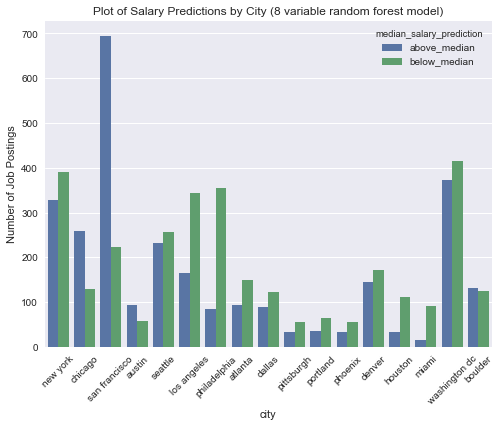

In [93]:
print(predict_data.salary_prediction.value_counts())

city_predictions = pd.DataFrame(predict_data[["city", "salary_prediction"]])

city_predictions['median_salary_prediction'] = city_predictions.salary_prediction.map({0:"below_median", 1:"above_median"})

sns.countplot(x="city", hue="median_salary_prediction", data=city_predictions)
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
sns.plt.title('Plot of Salary Predictions by City (8 variable random forest model)')
plt.show()


### Of 5950 job postings without salary information listed, my 8 feature random forest model predicts 3,114 (52%) as being below the median, while predicting 2,836 (48%) as being above the median.

### San Francisco is predicted to be the biggest hub of above_median salary jobs (unsurprisingly)

In [ ]:
# ##### I've evaluated each of my models above.  Summerizing findings here:

# ##### First logistic model - using eight binary variables on test data

# Score: 0.833333333333

# Confusion Matrix: 
# [[40  5]
#  [10 35]]

# Classification Matrix    
#              precision    recall  f1-score   support

#   below_med       0.80      0.89      0.84        45
#   above_med       0.88      0.78      0.82        45

# avg / total       0.84      0.83      0.83        90



# ##### Second logistic model - using tf-idf on X_test data

#Score: 0.733333333333

# Confusion Matrix:    
# [[35 10]
#  [14 31]]

# Classification Matrix    
#              precision    recall  f1-score   support

#   below_med       0.71      0.78      0.74        45
#   above_med       0.76      0.69      0.72        45

# avg / total       0.74      0.73      0.73        90 



# ##### Third model - random forest - using eight binary variables on X_test data

# Decision Tree Score: 0.815 ± 0.027 (on all data)
# Score: 0.8 (on test data)

# Confusion Matrix:    
# [[41  4]
#  [14 31]]

# Classification Matrix
#              precision    recall  f1-score   support

#   below_med       0.75      0.91      0.82        45
#   above_med       0.89      0.69      0.78        45

# avg / total       0.82      0.80      0.80        90
